# Digital Image Processing

Let's do stuff

In [1]:
from cubesolver.webcam import Webcam

import cv2
import skimage
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Camera calibration
cam = Webcam(0, downscale=5)
cam.calibrate((6,5))

Try to open camera...
Camera opened successfully
looking for (6, 5) chessboard


2023-06-27 21:47:56.906 Python[47045:1341047] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/w1/cmd2jfv1229gcxvtdyfg1vjc0000gn/T/org.python.python.savedState


True

Try to open camera...
Camera opened successfully


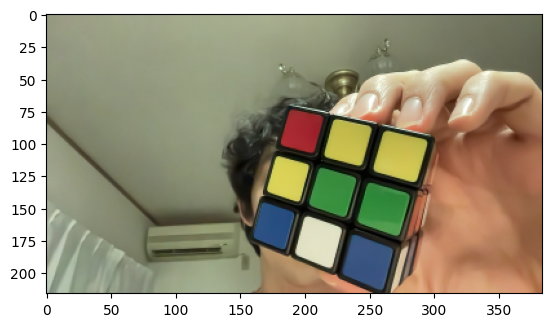

In [70]:
cam.open()
frame = np.zeros(1)
while np.allclose(0, frame):
    ret, frame = cam.get_frame()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cam.close()
plt.imshow(frame)

### Detecting with Edge Detection

In [71]:
%%time
# Change to grayscale
frame_gray = skimage.color.rgb2gray(frame)
frame_gray_eq = skimage.exposure.equalize_adapthist(frame_gray)

# Get edges
edges = skimage.feature.canny(frame_gray_eq, 1)

# Process edges
footprint = skimage.morphology.diamond(2)
cubies = skimage.morphology.dilation(edges, footprint)
cubies = skimage.util.invert(cubies)

cubies = skimage.morphology.remove_small_objects(cubies, 200)
cubies = skimage.segmentation.clear_border(cubies)

# Find cubie looking regions
cubie_labels, _ = scipy.ndimage.label(cubies, np.ones((3,3)))
regions = []
for region in skimage.measure.regionprops(cubie_labels):
    # Filter out big ares
    if region.area <= 2500 and region.extent > .5:
        minr, minc, maxr, maxc = region.bbox
        aratio = (maxr - minr) / (maxc - minc)
        # Take only square looking ones
        if np.abs(aratio - 1) < .3:
            regions.append(region)
            
if not regions:
    print("no regions")
    raise RuntimeError

# Create and apply mask
cube = np.any(np.stack([cubie_labels == r.label for r in regions], axis=2), axis=2)

footprint = skimage.morphology.disk(10)
mask = skimage.morphology.closing(cube, footprint)

mask_labels, mask_nlabels = scipy.ndimage.label(mask)

area = lambda labels, l: np.sum(labels == l)
biggest = np.max([area(mask_labels, l) for l in range(1, mask_nlabels + 1)])

if biggest < 2000:
    print("no cube")
    raise RuntimeError

mask = skimage.morphology.remove_small_objects(mask, biggest-1)
cube = np.logical_and(cube, mask)

CPU times: user 95.9 ms, sys: 5.82 ms, total: 102 ms
Wall time: 99.2 ms


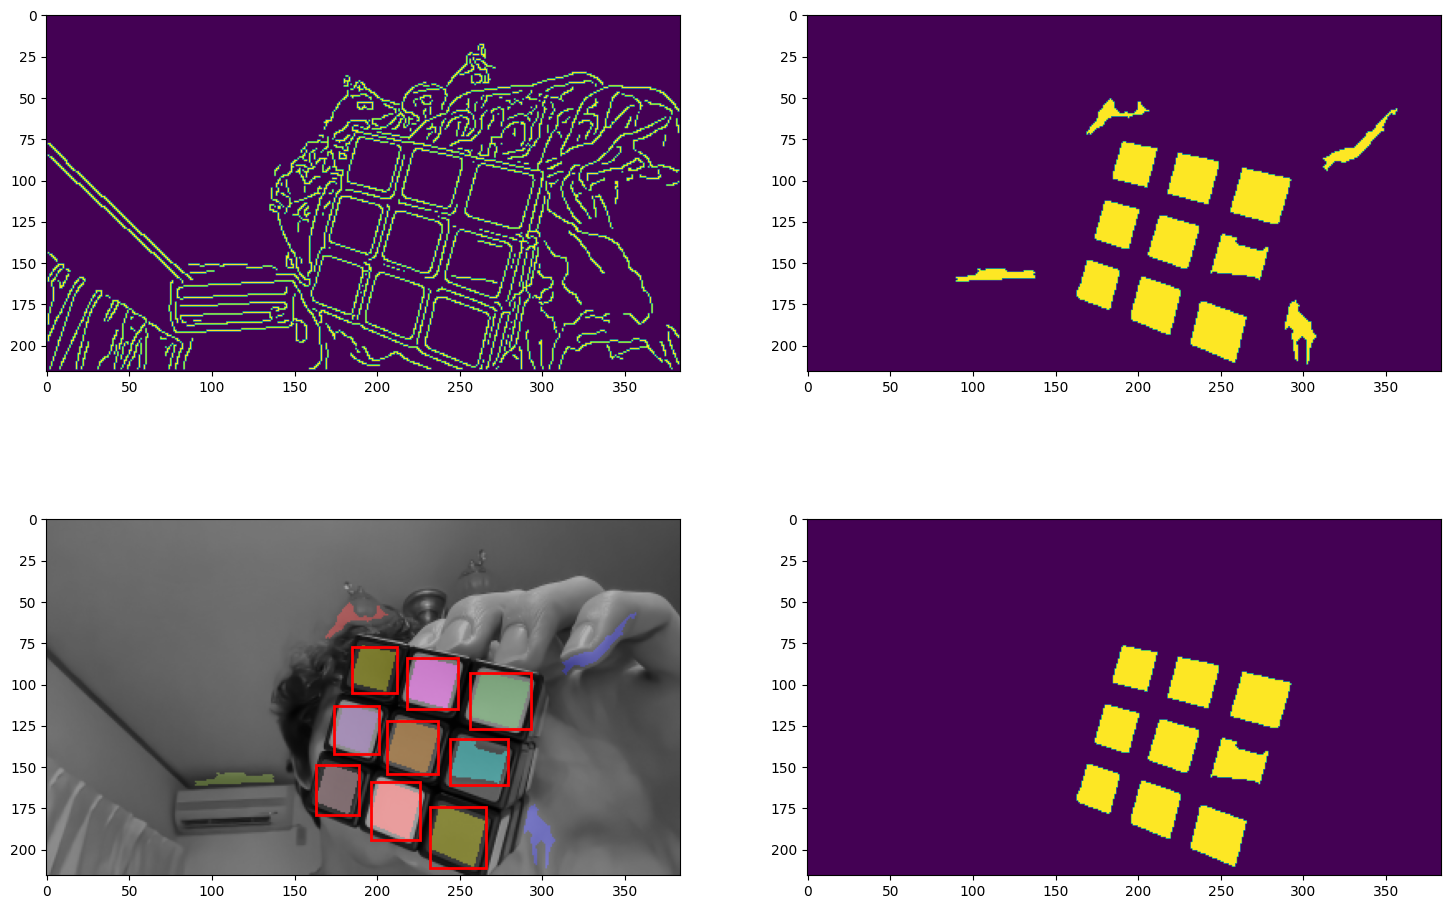

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))

axes[0, 0].imshow(edges)
axes[0, 1].imshow(cubies)
    
overlay = skimage.color.label2rgb(cubie_labels, image=frame_gray, bg_label=0)
axes[1, 0].imshow(overlay)
for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    axes[1, 0].add_patch(rect)
    
axes[1, 1].imshow(cube)

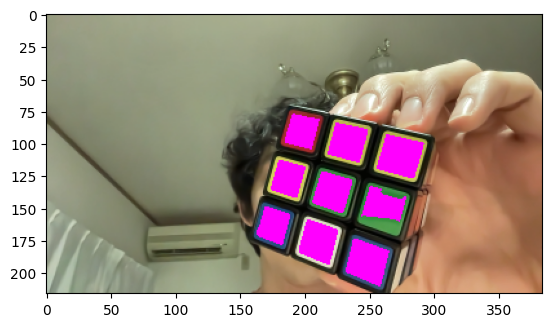

In [73]:
# Draw found cube faces
contours = skimage.measure.find_contours(cube)
fr = frame.copy()
fr[cube] = (255, 0, 255)

plt.imshow(fr)

In [74]:
# Get inverse of camera matrix
camera = cam.matrix
camera_inv = np.linalg.pinv(camera)

# Compute centroids
contours = skimage.measure.find_contours(cube)
centroids = np.array([np.mean(c, axis=0) for c in contours])

In [101]:
%%time
# probability of getting the best
p = .9999
ncentroids = centroids.shape[0]

if ncentroids <= 9:
    nruns = 10
else:
    u = 9 / ncentroids  # FIXME: this is not very accurate
    nruns = int(np.log(1. - p) / np.log(1. - u ** 3)) + 1

planes, errors = [], []
for _ in range(nruns):
    # Get random samples
    idxs = np.random.choice(centroids.shape[0], size=3, replace=False)
    sample = centroids[idxs, :]
    
    # Unproject points in 3d space
    points = np.vstack([sample[:, 0], sample[:, 1], np.ones((1, sample.shape[0]))]).T
    points = points @ camera_inv

    # Perform a regression to find plane
    z = points[:, 2]
    a = np.linalg.pinv(points.T @ points) @ points.T @ z

    normal = np.array((a[0], a[1], -1)) / a[2]
    normal = normal / np.linalg.norm(normal)

    # Compute regression error
    err = np.sum(np.abs(points @ normal))
    
    # Save data
    planes.append(normal)
    errors.append(err)

# Plane is given by n.T @ q = -1 for some q in R^3
planes = np.array(planes)
plane_normal = planes[np.argmin(errors)]

CPU times: user 2.24 ms, sys: 721 µs, total: 2.96 ms
Wall time: 2.43 ms


In [123]:
# Unproject centroids
points = np.vstack([centroids[:, 0], centroids[:, 1], np.ones((1, centroids.shape[0]))]).T
points = points @ camera_inv

# Create orthonormal system
first = points[0] - np.mean(points, axis=0)
first = first - (normal @ first) * normal
first = first / np.linalg.norm(first)

second = np.cross(normal, first)
second = second / np.linalg.norm(second)

plane_map = np.vstack([first, second, normal])
plane_imap = np.linalg.pinv(plane_map)

# Project points on plane
projections = points - (points @ normal)[:, None] * np.tile(normal, (points.shape[0], 1))
plane_projections = projections @ plane_map.T

# Find corners
topleft = np.min(centroids[:, 0]), np.min(centroids[:, 1])
bottomright = np.max(centroids[:, 0]), np.max(centroids[:, 1])

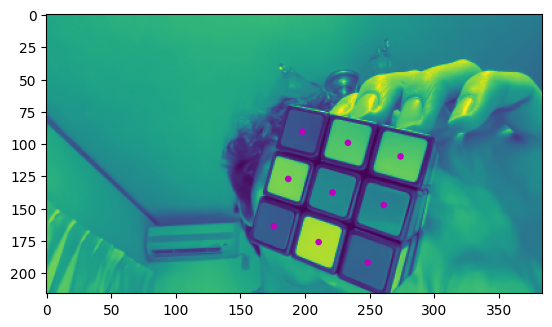

In [133]:
fig, ax = plt.subplots()

ax.imshow(frame_gray)

# Sanity check
for i in range(plane_projections.shape[0]):
    v = camera @ plane_imap @ plane_projections[i]
    xy = v[1], v[0]
    p = mpatches.Circle(xy, 2, color="m")
    ax.add_patch(p)

# for corner in (topleft, bottomright):
#     xy = corner[1], corner[0]
#     p = mpatches.Circle(xy, 2, color="w")
#     ax.add_patch(p)